In [1]:
#!/usr/bin/python

import time
import pprint
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from datetime import datetime, timedelta
import types
import TVAC_time_constants as TVAC_times
from load_data_files import load_mainhsk_names, load_mapping, load_minigoose, load_NASA_TCs, load_SFC, load_SFC_lists, load_var_names
from plotter_HELIX import make_plot, time_mask

In [2]:
from pip import main
file_name="Plum_Brook_Feb7_1400hr_to_End.json"
name_to_read=os.path.join(file_name)

data_path=os.path.dirname("Plum_Brook_Feb7_1400hr_to_End.json")

In [3]:
pp = pprint.PrettyPrinter(indent=4)

with open(name_to_read, 'r') as f:
    df = pd.json_normalize(json.load(f))
df.to_csv('json_file.csv')

In [4]:
print("Read in {} rows and with {} variables".format(df.shape[0], df.shape[1]))
print("  => First Timestamp: {}".format(df.iloc[0].server_timestamp))
print("  => Last Timestamp : {}".format(df.iloc[-1].server_timestamp))
names_payload=df.columns.values
print(type(df[names_payload[0]].values))
#np.savetxt('variable_names.txt',names_payload,fmt='%s')
# filter out zeros or whatever you like.  Do this before extracting times to keep
# the x/y arrays the same size.
df = df[(df['payload.fAbsolutePressure'] != 0)]

Read in 6050 rows and with 241 variables
  => First Timestamp: 2022-02-07 14:01:30.922000+00:00
  => Last Timestamp : 2022-02-09 17:17:50.063000+00:00
<class 'numpy.ndarray'>


In [5]:
# the time that the data were sent to the server is in server_timestamp
times = pd.to_datetime(df['server_timestamp'])
print(type(df['server_timestamp'].values[0]))
print(type(times[0]))
pressure  = df['payload.fAbsolutePressure']
sfc_temp  = df['payload.fSFCStatus.fCPU_Temp']
dini_temp = df['payload.fDiniTempFPGA']
richwest_power = df['payload.fPowerStat.fRICH_West.fPower']
dctboxtemp=df['payload.dctBoxTemp']
Magnet_probes=df['payload.fMagnetHSK.tempProbeAll']
#print(type(Magnet_probes.values))
#print(type(Magnet_probes.values[0]))
#print(Magnet_probes.values[0])

len(times)
payton = []
for i in range(0, 1044):
    payton.append(times[i])
for i in range(1045, 1203):
    payton.append(times[i])
for i in range(1204, 2378):
    payton.append(times[i])
for i in range(2379, 6050):
    payton.append(times[i])
#payton.append(times[1044])
len(payton)
pab = 40
'pa'+str(pab)


<class 'str'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


'pa40'

In [6]:
start_power=df.loc[df['payload.fPowerStat.fRICH_West.fPower']>100].index[0]
#start_power=times[df.iloc[df['payload.fPowerStat.fRICH_West.fPower']>100][0]]

mainhsk_temps  = df['payload.main_temps'].values
DCT_temps  = df['payload.dctThermistor'].values
heliumLVL=df['payload.fMagnetHSK.heliumLevels']

In [7]:
# to get just the first list element for each timestamp of the series...
#mainhsk_temps_array=np.empty([len(mainhsk_temps),len(mainhsk_temps[0])])
#temp_array=np.empty([len(mainhsk_temps[0]),])
temp_list=[]
for i in mainhsk_temps: temp_list.append(i)
mainhsk_temps_array=np.asarray(temp_list)
# now for DCT temps 
temp_list=[]
for i in DCT_temps: temp_list.append(i)
DCT_temps_array=np.asarray(temp_list)
#and helium levels
temp_list=[]
for i in heliumLVL: temp_list.append(i)
helium_levels_array=np.asarray(temp_list)
time_elapsed=pd.to_timedelta(times.values-times.values[0],unit='hours',errors="raise")
time_deltas=time_elapsed/timedelta(hours=1) # can also do minutes
mainhsk_names=pd.read_csv('mainhsk_temp_sensors.txt')
# legend/order of loading csvs i guess
NASA_names=pd.read_csv("keith_final_legend_order.csv")
#print(NASA_names.ID.values[2])
# NASA TCs loaded as a list first
NASA_TCs=[]
for name in NASA_names.ID:
    NASA_TCs.append(pd.read_csv(name+"_csv.csv",skiprows=1))
# convert NASA times to timestamp proper
#adjust to UTC like the other times
time_change = timedelta(hours=5)
for dfN in NASA_TCs:
    dfN['Times']=pd.to_datetime(dfN['Timestamp'])
    dfN['Times'] = dfN['Times'] + time_change

In [8]:
#j determines which slice of data
#dT is an amount of temperature we expect the next data point to be within. If the graph changes too rapidly it likely is due to
#some kind of bad data

def Masking(j, dT):
    mainhsk_temps_array_masked = np.copy(mainhsk_temps_array[:,j])
    #First attempt at a real mask. Assuming values should be some what continuous, put a condition that if the next value
    #differs by too much, then that element is candidate for bad value
    for i in range(1,6047):
        if abs(mainhsk_temps_array[i,j] - mainhsk_temps_array[i-1,j]) > dT and np.isnan(mainhsk_temps_array_masked[i-1]) == False:
            mainhsk_temps_array_masked[i] = np.nan
            k = np.copy(i)
            if np.isnan(mainhsk_temps_array_masked[k]):
                while abs(mainhsk_temps_array[k+1,j] - mainhsk_temps_array[k,j]) == 0:
                    if abs(mainhsk_temps_array[i-1,j] - mainhsk_temps_array[k,j]) > dT:
                        mainhsk_temps_array_masked[k] = np.nan
                        k = k + 1
        if np.isnan(mainhsk_temps_array_masked[i-1]) == True and abs(mainhsk_temps_array[i,j] - mainhsk_temps_array[i-1,j]) == 0:
            mainhsk_temps_array_masked[i] = np.nan
    #for i in range(2,6047):
     #   if abs(mainhsk_temps_array[i,j] - 2*mainhsk_temps_array[i-1,j] + mainhsk_temps_array[i-2,j]) > dl:
      #      mainhsk_temps_array_masked[i] = np.nan
    
    return mainhsk_temps_array_masked

In [9]:
keith = ['Coldest', 'Cold', 'Hot', 'Flip']

In [3]:
keith[0]

'Coldest'

In [40]:
def GraphMaker():
    ChosenGraphs = []
    d = {'data': ['Original with Masking', "Just Masking"], 'Input Number': [0,1]}
    dfd = pd.DataFrame(data=d)
    mainhsk_temp_sensors = pd.read_csv('mainhsk_temp_sensors.txt')
    print("How many graphs would you like to look at at once?")
    print("If you would like to look at all the RICH graphs you may type in 'RICH'.")
    Ngraph = input()
    #print("Which of the following parts do you want to look at?")
    #I = int(input())
    if str.isnumeric(Ngraph) == True:
        while int(Ngraph) > 26 or int(Ngraph) <= 0:
            print("Alright, lets not be an asshole now.")
            Ngraph = input()
            while str.isnumeric(Ngraph) == False:
                print("You picked a number before, why are you picking not a number now? Be consistant man.")
                Ngraph = input()
        print(mainhsk_temp_sensors)
        print("Which graphs would you like to look at?")
        for i in range(0, int(Ngraph), 1):
            I = int(input())
            if I > 25 or I < 0:
                print("Bro, come on.")
                I = int(input())
            else:
                ChosenGraphs.append(I)
        print("Do you want the original data too or just the masked data?")
        print(dfd)
        Dchoice = int(input())
        while Dchoice < 0 or Dchoice > 1:
            print("Fuck you, pick again.")
            Dchoice = int(input())
        if Dchoice == 1:
            # Now make a plot
            fig = plt.figure(figsize=(20, int(Ngraph)*3), dpi=200)
            for i in range(0,int(Ngraph),1):
                axs=fig.add_subplot(int(np.ceil(int(Ngraph)/2)),2,i+1)
                gs = fig.add_gridspec(1, 1)
                #axs = gs.subplots(sharex=True, sharey=False)
                #axs = gs.subplots()
                #axs.scatter(times, pressure, marker='.')
                #axs.set_ylabel("Pressure (Torr)")
                #axs.set_ylim([1, 759])
                # need timestamps to use here for cold wall begin filling and ending and then hot and cold cases respectively.
                # datetime(year, month, day, hour, minute, second, microsecond)
                #b = datetime(2017, 11, 28, 23, 55, 59, 342380)
                cold_wall_fill_start = datetime(2022, 2, 7,21,0,0,0)
                cold_wall_fill_end = datetime(2022, 2, 8,0,22,0,0)
                power_on_DAQ = times[start_power]
                cold_case_start=datetime(2022, 2, 8,1,6,0,0)
                cold_case_end=datetime(2022, 2, 8,7,14,0,0)
                hot_case_start=cold_case_end
                hot_case_end=datetime(2022, 2, 8,17,30,0,0)
                kickflip_start=hot_case_end
                discharge_magnet = datetime(2022,2,8,20,35,0,0)
                discharge_magnet_ps_off = datetime(2022,2,8,22,36,0,0)
                drain_cold_wall_begin=datetime(2022,2,9,00,00,0,0)
                #kickflip_end=datetime(2022, 2, 9,00,00,0,0) # not sure this actually stopped until during warm up
                cold_wall_at_7ft=datetime(2022,2,9,4,00,0,0)
                cold_wall_at_neg_6_deg=datetime(2022,2,9,7,37,0,0)
                kickflip_end=datetime(2022,2,9,7,46,0,0)
                slight_warmup_start=datetime(2022,2,9,10,52,0,0)
                drain_cold_wall_end=datetime(2022,2,9,12,45,0,0)
                slight_warmup_end=datetime(2022,2,9,12,45,0,0)
                evacuation_start = datetime(2022,2,7,17,45,0,0)
                evacuation_end = datetime(2022,2,9,17,00,0,0)
                DAQ_Run = datetime(2022,2,8,5,41,0,0)
                DAQ_Run_2 = datetime(2022,2,9,0,10,0,0)
                heater_start=datetime(2022,2,8,13,18,0,0)
                heater_max=datetime(2022,2,8,18,52,0,0)
                # hatches for timespans
                axs.axvspan(cold_wall_fill_start, cold_wall_fill_end, alpha=0.1, color='royalblue',label="cold wall fill")
                axs.axvspan(cold_case_start, cold_case_end, alpha=0.1, color='cyan', label="cold case")
                axs.axvspan(hot_case_start,hot_case_end , alpha=0.1, color='firebrick', label="hot case")
                axs.axvspan(kickflip_start,kickflip_end , alpha=0.3, hatch="XXX", color='darkorange', label="flipped hot case")
                axs.axvspan(drain_cold_wall_begin,drain_cold_wall_end , alpha=0.1, color='royalblue', label="draining cold wall")
                axs.axvspan(slight_warmup_start,slight_warmup_end , alpha=0.3, color='red', label="slight warm up")
                #size for markers visibility
                s0=40
                sM = 30
                #axs.scatter(times, mainhsk_temps_array[:,ChosenGraphs[i]], marker='x',s=s0,label=mainhsk_names.Location.values[ChosenGraphs[i]])
                if ChosenGraphs[i] == 12 or ChosenGraphs[i] == 24:
                    dT = 2
                    axs.scatter(times, Masking(ChosenGraphs[i],dT), marker='.',s=sM,label=mainhsk_names.Location.values[ChosenGraphs[i]])
                elif ChosenGraphs[i] == 11:
                    dT = 1.5
                    axs.scatter(times, Masking(ChosenGraphs[i],dT), marker='.',s=sM,label=mainhsk_names.Location.values[ChosenGraphs[i]])
                elif ChosenGraphs[i] == 7 or ChosenGraphs[i] == 13:
                    dT = 3
                    axs.scatter(times, Masking(ChosenGraphs[i],dT), marker='.',s=sM,label=mainhsk_names.Location.values[ChosenGraphs[i]])
                elif ChosenGraphs[i] == 14:
                    dT = 2.5
                    axs.scatter(times, Masking(ChosenGraphs[i],dT), marker='.',s=sM,label=mainhsk_names.Location.values[ChosenGraphs[i]])
                elif ChosenGraphs[i] == 6:
                    dT = .75
                    axs.scatter(times, Masking(ChosenGraphs[i],dT), marker='.',s=sM,label=mainhsk_names.Location.values[ChosenGraphs[i]])
                else:
                    dT = 1
                    axs.scatter(times, Masking(ChosenGraphs[i],dT), marker='.',s=sM,label=mainhsk_names.Location.values[ChosenGraphs[i]])
                axs.set_ylabel("Temps (C)")
                plt.xticks(rotation=45)
                plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d - %H:%M'))
                plt.gcf().autofmt_xdate()
                #axs.legend(loc='upper center', ncol=4, fontsize=8)
                #axs[0].grid()
                axs.grid()
                #plt.legend(loc='upper center', fontsize=8)
                handles, labels = axs.get_legend_handles_labels()
                #legends.append(handles)
                #lgd = axs[1].legend(handles, labels)
                #for legend_handle in lgd.legendHandles:
                #    legend_handle.set_sizes([20])
                #labels[6]._legmarker.set_markersize(6)
                axs.legend(handles, labels, loc='upper center', ncol=4, fontsize=8)
                #plt.legend(loc='upper center', ncol=4, fontsize=8)
                # as many of these as axs[1].scatter above
        else:
            # Now make a plot
            fig = plt.figure(figsize=(20, int(Ngraph)*3), dpi=200)
            for i in range(0,int(Ngraph),1):
                axs=fig.add_subplot(int(np.ceil(int(Ngraph)/2)),2,i+1)
                gs = fig.add_gridspec(1, 1)
                #axs = gs.subplots(sharex=True, sharey=False)
                #axs = gs.subplots()
                #axs.scatter(times, pressure, marker='.')
                #axs.set_ylabel("Pressure (Torr)")
                #axs.set_ylim([1, 759])
                # need timestamps to use here for cold wall begin filling and ending and then hot and cold cases respectively.
                # datetime(year, month, day, hour, minute, second, microsecond)
                #b = datetime(2017, 11, 28, 23, 55, 59, 342380)
                cold_wall_fill_start = datetime(2022, 2, 7,21,0,0,0)
                cold_wall_fill_end = datetime(2022, 2, 8,0,22,0,0)
                power_on_DAQ = times[start_power]
                cold_case_start=datetime(2022, 2, 8,1,6,0,0)
                cold_case_end=datetime(2022, 2, 8,7,14,0,0)
                hot_case_start=cold_case_end
                hot_case_end=datetime(2022, 2, 8,17,30,0,0)
                kickflip_start=hot_case_end
                discharge_magnet = datetime(2022,2,8,20,35,0,0)
                discharge_magnet_ps_off = datetime(2022,2,8,22,36,0,0)
                drain_cold_wall_begin=datetime(2022,2,9,00,00,0,0)
                #kickflip_end=datetime(2022, 2, 9,00,00,0,0) # not sure this actually stopped until during warm up
                cold_wall_at_7ft=datetime(2022,2,9,4,00,0,0)
                cold_wall_at_neg_6_deg=datetime(2022,2,9,7,37,0,0)
                kickflip_end=datetime(2022,2,9,7,46,0,0)
                slight_warmup_start=datetime(2022,2,9,10,52,0,0)
                drain_cold_wall_end=datetime(2022,2,9,12,45,0,0)
                slight_warmup_end=datetime(2022,2,9,12,45,0,0)
                evacuation_start = datetime(2022,2,7,17,45,0,0)
                evacuation_end = datetime(2022,2,9,17,00,0,0)
                DAQ_Run = datetime(2022,2,8,5,41,0,0)
                DAQ_Run_2 = datetime(2022,2,9,0,10,0,0)
                heater_start=datetime(2022,2,8,13,18,0,0)
                heater_max=datetime(2022,2,8,18,52,0,0)
                # hatches for timespans
                axs.axvspan(cold_wall_fill_start, cold_wall_fill_end, alpha=0.1, color='royalblue',label="cold wall fill")
                axs.axvspan(cold_case_start, cold_case_end, alpha=0.1, color='cyan', label="cold case")
                axs.axvspan(hot_case_start,hot_case_end , alpha=0.1, color='firebrick', label="hot case")
                axs.axvspan(kickflip_start,kickflip_end , alpha=0.3, hatch="XXX", color='darkorange', label="flipped hot case")
                axs.axvspan(drain_cold_wall_begin,drain_cold_wall_end , alpha=0.1, color='royalblue', label="draining cold wall")
                axs.axvspan(slight_warmup_start,slight_warmup_end , alpha=0.3, color='red', label="slight warm up")
                #size for markers visibility
                s0=40
                sM = 30
                axs.scatter(times, mainhsk_temps_array[:,ChosenGraphs[i]], marker='x',s=s0,label=mainhsk_names.Location.values[ChosenGraphs[i]])
                if ChosenGraphs[i] == 12 or ChosenGraphs[i] == 24:
                    dT = 2
                    axs.scatter(times, Masking(ChosenGraphs[i],dT), marker='.',s=sM,label=mainhsk_names.Location.values[ChosenGraphs[i]])
                elif ChosenGraphs[i] == 11:
                    dT = 1.5
                    axs.scatter(times, Masking(ChosenGraphs[i],dT), marker='.',s=sM,label=mainhsk_names.Location.values[ChosenGraphs[i]])
                elif ChosenGraphs[i] == 7 or ChosenGraphs[i] == 13:
                    dT = 3
                    axs.scatter(times, Masking(ChosenGraphs[i],dT), marker='.',s=sM,label=mainhsk_names.Location.values[ChosenGraphs[i]])
                elif ChosenGraphs[i] == 14:
                    dT = 2.5
                    axs.scatter(times, Masking(ChosenGraphs[i],dT), marker='.',s=sM,label=mainhsk_names.Location.values[ChosenGraphs[i]])
                elif ChosenGraphs[i] == 6:
                    dT = .75
                    axs.scatter(times, Masking(ChosenGraphs[i],dT), marker='.',s=sM,label=mainhsk_names.Location.values[ChosenGraphs[i]])
                else:
                    dT = 1
                    axs.scatter(times, Masking(ChosenGraphs[i],dT), marker='.',s=sM,label=mainhsk_names.Location.values[ChosenGraphs[i]])
                axs.set_ylabel("Temps (C)")
                plt.xticks(rotation=45)
                plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d - %H:%M'))
                plt.gcf().autofmt_xdate()
                #axs.legend(loc='upper center', ncol=4, fontsize=8)
                #axs[0].grid()
                axs.grid()
                #plt.legend(loc='upper center', fontsize=8)
                handles, labels = axs.get_legend_handles_labels()
                #legends.append(handles)
                #lgd = axs[1].legend(handles, labels)
                #for legend_handle in lgd.legendHandles:
                #    legend_handle.set_sizes([20])
                #labels[6]._legmarker.set_markersize(6)
                axs.legend(handles, labels, loc='upper center', ncol=4, fontsize=8)
                #plt.legend(loc='upper center', ncol=4, fontsize=8)
                # as many of these as axs[1].scatter above
    if str.isnumeric(Ngraph) == False:
        if Ngraph == "RICH":
            print("Do you want the original data too or just the masked data?")
            print(dfd)
            Dchoice = int(input())
        while Dchoice < 0 or Dchoice > 1:
            print("Fuck you, pick again.")
            Dchoice = int(input())
        if Dchoice == 1:
            # Now make a plot
            fig = plt.figure(figsize=(20, 25), dpi=200)
            z = 1
            for i in [0,9,17,18,19,23]:
                axs=fig.add_subplot(3,2,z)
                z = z + 1
                gs = fig.add_gridspec(1, 1)
                #axs = gs.subplots(sharex=True, sharey=False)
                #axs = gs.subplots()
                #axs.scatter(times, pressure, marker='.')
                #axs.set_ylabel("Pressure (Torr)")
                #axs.set_ylim([1, 759])
                # need timestamps to use here for cold wall begin filling and ending and then hot and cold cases respectively.
                # datetime(year, month, day, hour, minute, second, microsecond)
                #b = datetime(2017, 11, 28, 23, 55, 59, 342380)
                cold_wall_fill_start = datetime(2022, 2, 7,21,0,0,0)
                cold_wall_fill_end = datetime(2022, 2, 8,0,22,0,0)
                power_on_DAQ = times[start_power]
                cold_case_start=datetime(2022, 2, 8,1,6,0,0)
                cold_case_end=datetime(2022, 2, 8,7,14,0,0)
                hot_case_start=cold_case_end
                hot_case_end=datetime(2022, 2, 8,17,30,0,0)
                kickflip_start=hot_case_end
                discharge_magnet = datetime(2022,2,8,20,35,0,0)
                discharge_magnet_ps_off = datetime(2022,2,8,22,36,0,0)
                drain_cold_wall_begin=datetime(2022,2,9,00,00,0,0)
                #kickflip_end=datetime(2022, 2, 9,00,00,0,0) # not sure this actually stopped until during warm up
                cold_wall_at_7ft=datetime(2022,2,9,4,00,0,0)
                cold_wall_at_neg_6_deg=datetime(2022,2,9,7,37,0,0)
                kickflip_end=datetime(2022,2,9,7,46,0,0)
                slight_warmup_start=datetime(2022,2,9,10,52,0,0)
                drain_cold_wall_end=datetime(2022,2,9,12,45,0,0)
                slight_warmup_end=datetime(2022,2,9,12,45,0,0)
                evacuation_start = datetime(2022,2,7,17,45,0,0)
                evacuation_end = datetime(2022,2,9,17,00,0,0)
                DAQ_Run = datetime(2022,2,8,5,41,0,0)
                DAQ_Run_2 = datetime(2022,2,9,0,10,0,0)
                heater_start=datetime(2022,2,8,13,18,0,0)
                heater_max=datetime(2022,2,8,18,52,0,0)
                # hatches for timespans
                axs.axvspan(cold_wall_fill_start, cold_wall_fill_end, alpha=0.1, color='royalblue',label="cold wall fill")
                axs.axvspan(cold_case_start, cold_case_end, alpha=0.1, color='cyan', label="cold case")
                axs.axvspan(hot_case_start,hot_case_end , alpha=0.1, color='firebrick', label="hot case")
                axs.axvspan(kickflip_start,kickflip_end , alpha=0.3, hatch="XXX", color='darkorange', label="flipped hot case")
                axs.axvspan(drain_cold_wall_begin,drain_cold_wall_end , alpha=0.1, color='royalblue', label="draining cold wall")
                axs.axvspan(slight_warmup_start,slight_warmup_end , alpha=0.3, color='red', label="slight warm up")
                #size for markers visibility
                s0=40
                sM = 30
                #axs.scatter(times, mainhsk_temps_array[:,ChosenGraphs[i]], marker='x',s=s0,label=mainhsk_names.Location.values[ChosenGraphs[i]])
                dT = 1
                axs.scatter(times, Masking(i,dT), marker='.',s=sM,label=mainhsk_names.Location.values[i])
                axs.set_ylabel("Temps (C)")
                plt.xticks(rotation=45)
                plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d - %H:%M'))
                plt.gcf().autofmt_xdate()
                #axs.legend(loc='upper center', ncol=4, fontsize=8)
                #axs[0].grid()
                axs.grid()
                #plt.legend(loc='upper center', fontsize=8)
                handles, labels = axs.get_legend_handles_labels()
                #legends.append(handles)
                #lgd = axs[1].legend(handles, labels)
                #for legend_handle in lgd.legendHandles:
                #    legend_handle.set_sizes([20])
                #labels[6]._legmarker.set_markersize(6)
                axs.legend(handles, labels, loc='upper center', ncol=4, fontsize=8)
                #plt.legend(loc='upper center', ncol=4, fontsize=8)
                # as many of these as axs[1].scatter above
        else:
            # Now make a plot
            fig = plt.figure(figsize=(20,25), dpi = 200)
            z = 1
            for i in [0,9,17,18,19,23]:
                axs=fig.add_subplot(3,2,z)
                z = z + 1
                gs = fig.add_gridspec(1, 1)
                #axs = gs.subplots(sharex=True, sharey=False)
                #axs = gs.subplots()
                #axs.scatter(times, pressure, marker='.')
                #axs.set_ylabel("Pressure (Torr)")
                #axs.set_ylim([1, 759])
                # need timestamps to use here for cold wall begin filling and ending and then hot and cold cases respectively.
                # datetime(year, month, day, hour, minute, second, microsecond)
                #b = datetime(2017, 11, 28, 23, 55, 59, 342380)
                cold_wall_fill_start = datetime(2022, 2, 7,21,0,0,0)
                cold_wall_fill_end = datetime(2022, 2, 8,0,22,0,0)
                power_on_DAQ = times[start_power]
                cold_case_start=datetime(2022, 2, 8,1,6,0,0)
                cold_case_end=datetime(2022, 2, 8,7,14,0,0)
                hot_case_start=cold_case_end
                hot_case_end=datetime(2022, 2, 8,17,30,0,0)
                kickflip_start=hot_case_end
                discharge_magnet = datetime(2022,2,8,20,35,0,0)
                discharge_magnet_ps_off = datetime(2022,2,8,22,36,0,0)
                drain_cold_wall_begin=datetime(2022,2,9,00,00,0,0)
                #kickflip_end=datetime(2022, 2, 9,00,00,0,0) # not sure this actually stopped until during warm up
                cold_wall_at_7ft=datetime(2022,2,9,4,00,0,0)
                cold_wall_at_neg_6_deg=datetime(2022,2,9,7,37,0,0)
                kickflip_end=datetime(2022,2,9,7,46,0,0)
                slight_warmup_start=datetime(2022,2,9,10,52,0,0)
                drain_cold_wall_end=datetime(2022,2,9,12,45,0,0)
                slight_warmup_end=datetime(2022,2,9,12,45,0,0)
                evacuation_start = datetime(2022,2,7,17,45,0,0)
                evacuation_end = datetime(2022,2,9,17,00,0,0)
                DAQ_Run = datetime(2022,2,8,5,41,0,0)
                DAQ_Run_2 = datetime(2022,2,9,0,10,0,0)
                heater_start=datetime(2022,2,8,13,18,0,0)
                heater_max=datetime(2022,2,8,18,52,0,0)
                # hatches for timespans
                axs.axvspan(cold_wall_fill_start, cold_wall_fill_end, alpha=0.1, color='royalblue',label="cold wall fill")
                axs.axvspan(cold_case_start, cold_case_end, alpha=0.1, color='cyan', label="cold case")
                axs.axvspan(hot_case_start,hot_case_end , alpha=0.1, color='firebrick', label="hot case")
                axs.axvspan(kickflip_start,kickflip_end , alpha=0.3, hatch="XXX", color='darkorange', label="flipped hot case")
                axs.axvspan(drain_cold_wall_begin,drain_cold_wall_end , alpha=0.1, color='royalblue', label="draining cold wall")
                axs.axvspan(slight_warmup_start,slight_warmup_end , alpha=0.3, color='red', label="slight warm up")
                #size for markers visibility
                s0=40
                sM = 30
                axs.scatter(times, mainhsk_temps_array[:,i], marker='x',s=s0,label=mainhsk_names.Location.values[i])
                dT = 1
                axs.scatter(times, Masking(i,dT), marker='.',s=sM,label=mainhsk_names.Location.values[i])
                axs.set_ylabel("Temps (C)")
                plt.xticks(rotation=45)
                plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d - %H:%M'))
                plt.gcf().autofmt_xdate()
                #axs.legend(loc='upper center', ncol=4, fontsize=8)
                #axs[0].grid()
                axs.grid()
                #plt.legend(loc='upper center', fontsize=8)
                handles, labels = axs.get_legend_handles_labels()
                #legends.append(handles)
                #lgd = axs[1].legend(handles, labels)
                #for legend_handle in lgd.legendHandles:
                #    legend_handle.set_sizes([20])
                #labels[6]._legmarker.set_markersize(6)
                axs.legend(handles, labels, loc='upper center', ncol=4, fontsize=8)
                #plt.legend(loc='upper center', ncol=4, fontsize=8)
                # as many of these as axs[1].scatter above
    
    return plt.show()

How many graphs would you like to look at at once?
If you would like to look at all the RICH graphs you may type in 'RICH'.
1
                          Location  Array index
0                   RICH FP btm SW            0
1                         DCTV top            1
2                       DCT HV box            2
3                    Gondola btm S            3
4                    Gondola btm W            4
5                        TOF btm S            5
6                    SFC backplate            6
7                        TOF top S            7
8                    Gondola mid S            8
9                     RICH cover S            9
10         DCTV bottom/Bore paddle           10
11       bore paddle readout board           11
12       TOF top E-FEE thermal bar           12
13  Gondola mid E on RICH heatsink           13
14  Gondola mid W on RICH heatsink           14
15                       Gas panel           15
16                       TOF btm N           16
17        

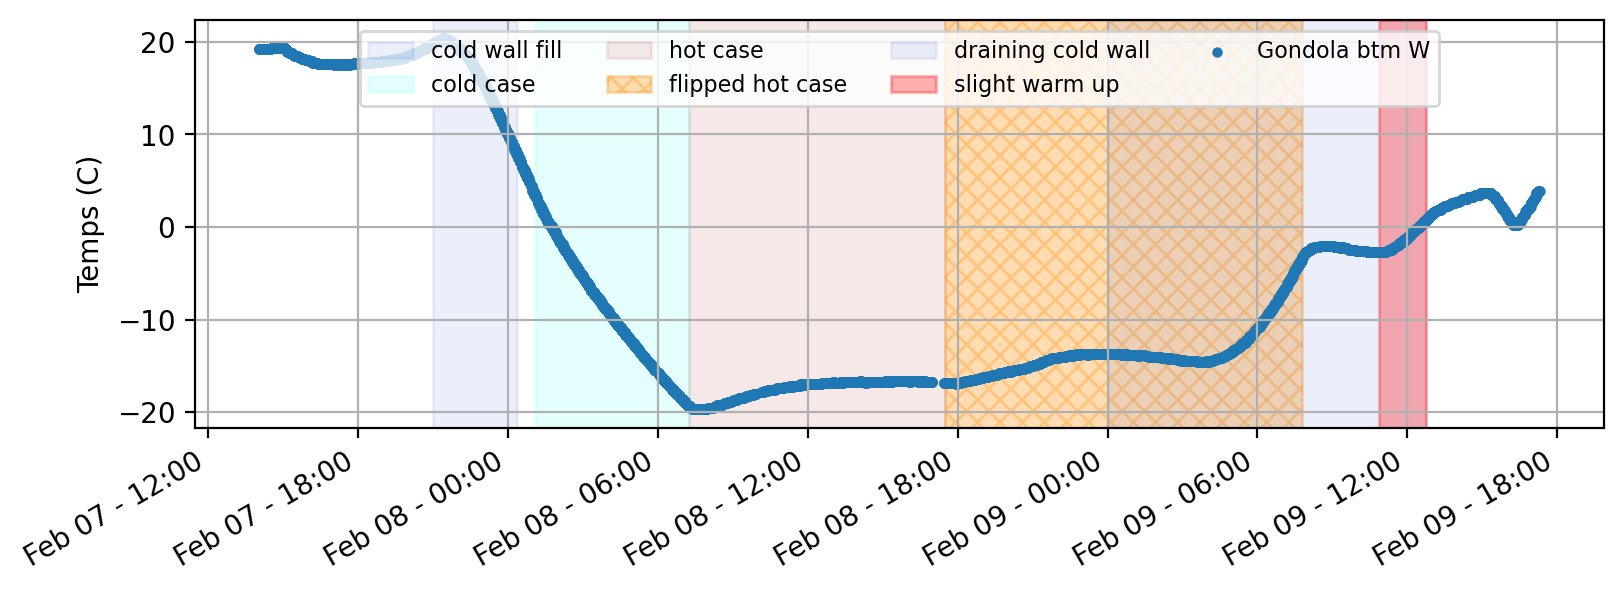

In [41]:
GraphMaker()

C:\Users\17243\Documents\GitHub\Helix_Temp_Masking\Helix_Temp_Stuff
C:\Users\17243\Documents\GitHub\Helix_Temp_Masking\Helix_Temp_Stuff
Read in 6050 rows and with 241 variables
  => First Timestamp: 2022-02-07 14:01:30.922000+00:00
  => Last Timestamp : 2022-02-09 17:17:50.063000+00:00
<class 'numpy.ndarray'>
total times
__________________
Coldest case: 4:06:00
Cold case: 6:08:00
Hot case: 10:16:00
Flip case: 6:30:00
Cold Wall ON: 22:54:00


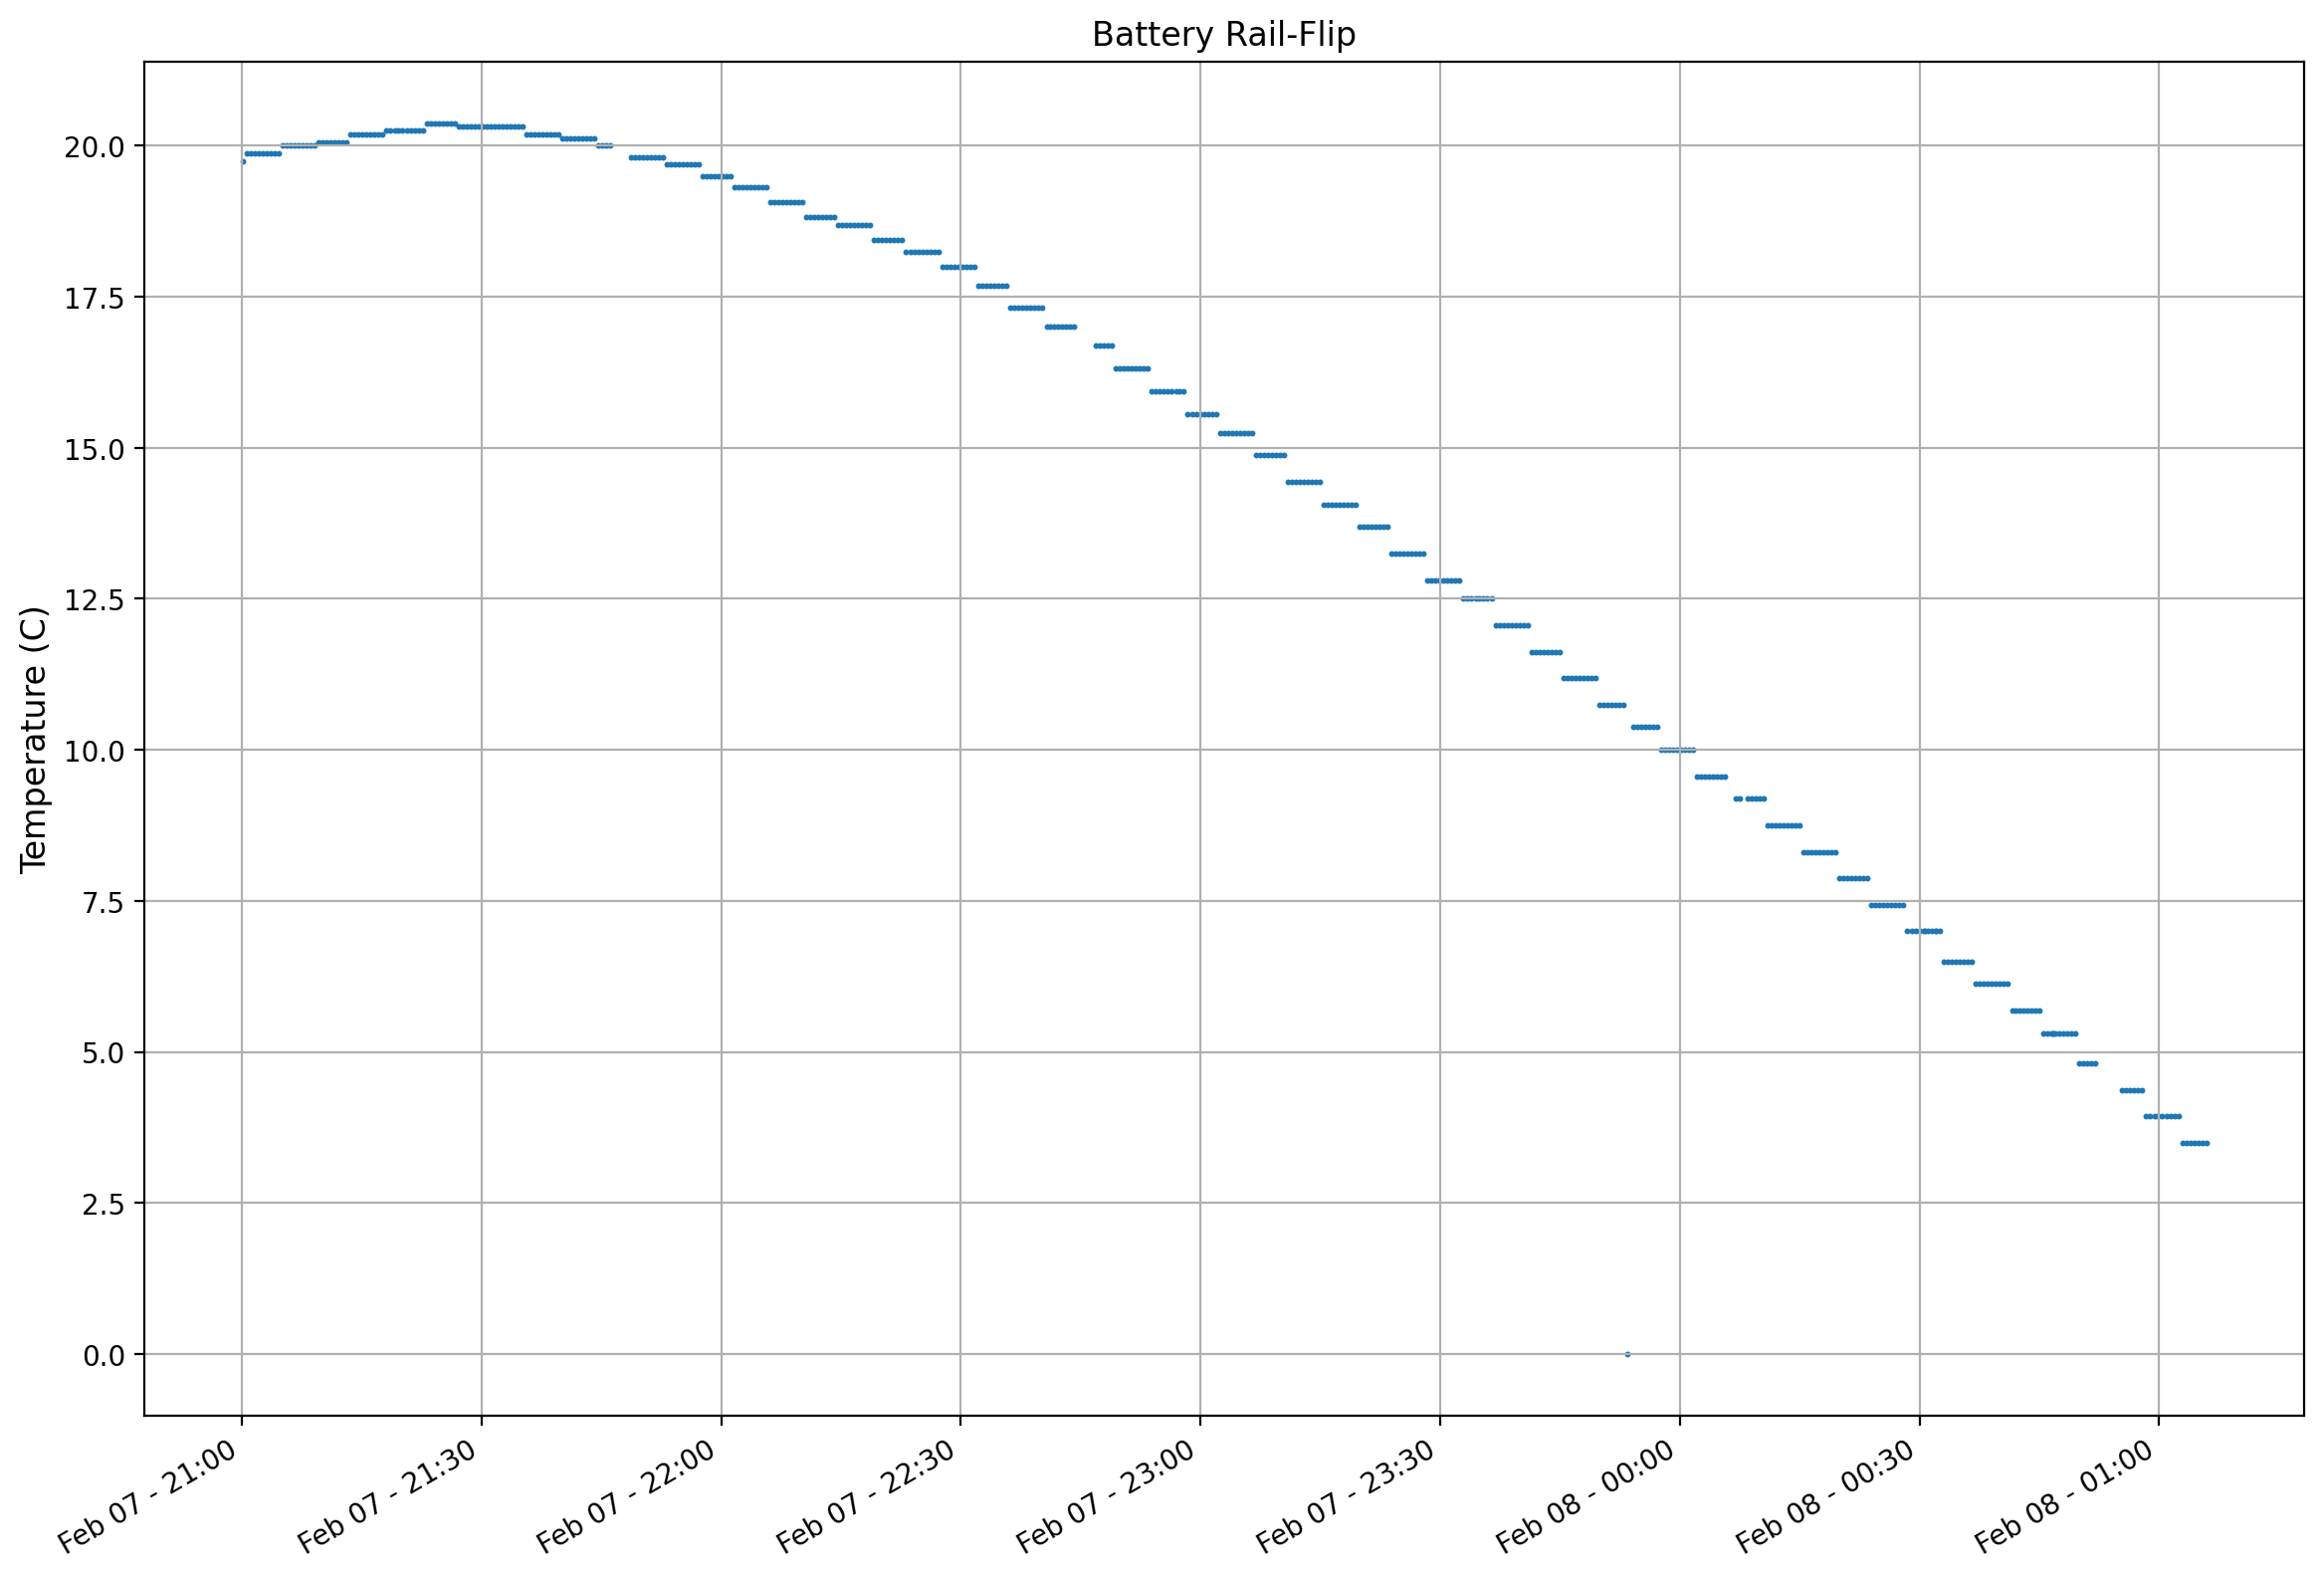

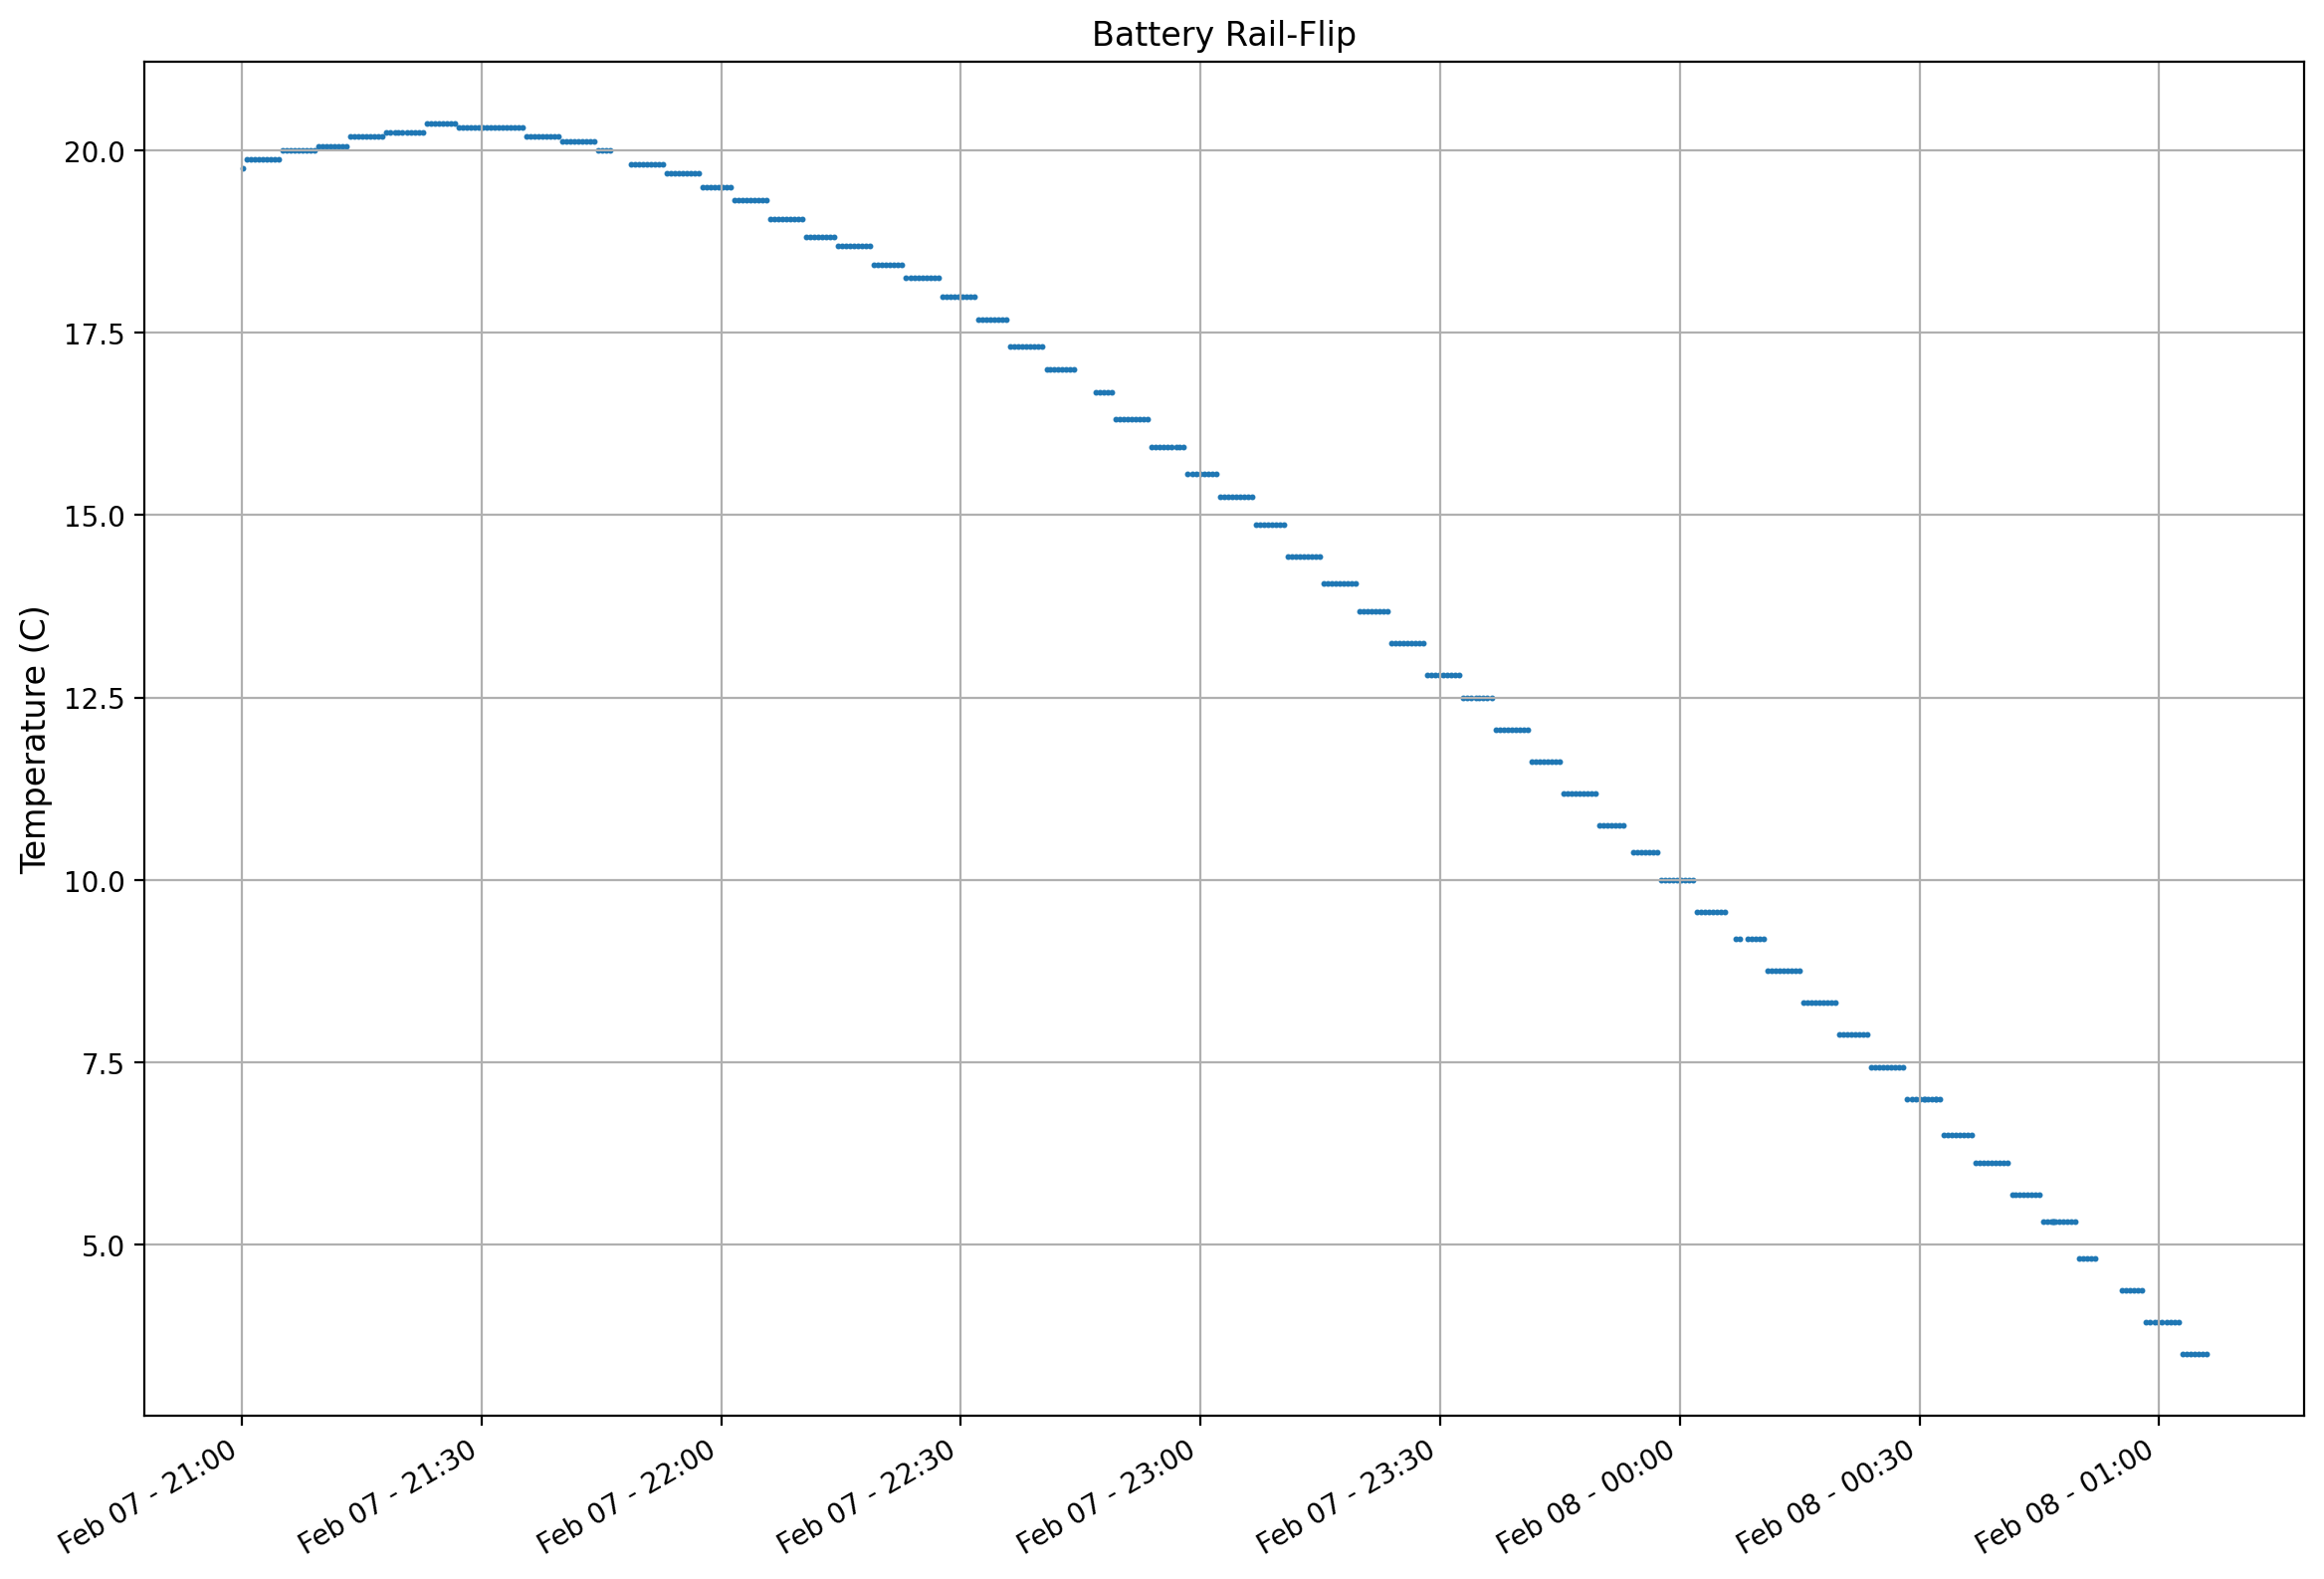

In [26]:
times, df = load_SFC(1)
Xadc_array, magnetflows_array, mainhsk_temps_array, DCT_temps_array, helium_levels_array = load_SFC_lists(times,df)
mainhsk_names = load_mainhsk_names(1)
TVAC_times.all_delta_times(1)
x1,y1=time_mask(times, mainhsk_temps_array[:,4],'Coldest')
#x2,y2=time_mask(times, mainhsk_temps_array[:,4],'Cold')
#x3,y3=time_mask(times, mainhsk_temps_array[:,4],'Hot')
#x4,y4=time_mask(times, mainhsk_temps_array[:,4],'Flip')
x2,y2=time_mask(times, Masking(4, 1), 'Coldest')

#fig, axs = plt.subplots(2, 2)
#axs[0, 0].plot(x1, y1, 'tab:red')
#axs[0, 1].plot(x2, y2, 'tab:red')
#axs[1, 0].plot(x3, y3, 'tab:red')
#axs[1, 1].plot(x4, y4, 'tab:red')

make_plot(x1,y1,'Battery Rail-Flip')
make_plot(x2,y2,'Battery Rail-Flip')
#make_plot(x3,y3,'Battery Rail-Flip')
#make_plot(x4,y4,'Battery Rail-Flip')

In [58]:
def QuadGraphMaker():
    ChosenGraphs = []
    d = {'data': ['Original with Masking', "Just Masking"], 'Input Number': [0,1]}
    dfd = pd.DataFrame(data=d)
    mainhsk_temp_sensors = pd.read_csv('mainhsk_temp_sensors.txt')
    print("How many variables would you like to look at at once?")
    #print("If you would like to look at all the RICH graphs you may type in 'RICH'.")
    Ngraph = input()
    #print("Which of the following parts do you want to look at?")
    #I = int(input())
    #if str.isnumeric(Ngraph) == True:
    while int(Ngraph) > 26 or int(Ngraph) <= 0:
        print("Alright, lets not be an asshole now.")
        Ngraph = input()
            #while str.isnumeric(Ngraph) == False:
                #print("You picked a number before, why are you picking not a number now? Be consistant man.")
                #Ngraph = input()
    print(mainhsk_temp_sensors)
    print("Which variables would you like to look at?")
    for i in range(0, int(Ngraph), 1):
        I = int(input())
        if I > 25 or I < 0:
            print("Bro, come on.")
            I = int(input())
        else:
            ChosenGraphs.append(I)
    print("Do you want the original data too or just the masked data?")
    print(dfd)
    Dchoice = int(input())
    while Dchoice < 0 or Dchoice > 1:
        print("Fuck you, pick again.")
        Dchoice = int(input())
    if Dchoice == 1:
        # Now make a plot
        #fig = plt.figure(figsize=(20, 20), dpi=200)
        fig = plt.figure(figsize=(20, 80*int(Ngraph)), dpi=200)
        j = 0
        for i in range(0,4*int(Ngraph),1):
            if i%4 == 0 and i != 0:
                j = j + 1
            #print(i,j)
            axs=fig.add_subplot(int(2*Ngraph),2,i+1)
            gs = fig.add_gridspec(1, 1)
            #x1,y1=time_mask(times, mainhsk_temps_array[:,ChosenGraphs[j]],keith[i%4])
            #s0=5
            #axs.scatter(x1, y1, marker='x',s=s0, label=mainhsk_names.Location.values[ChosenGraphs[j]])  # DCTV top
            #if y_range is not None:
             #   axs.set_ylim([y_range[-1], y_range[0]])
            #axs.set_ylim([-20, 39])
            plt.xticks(rotation=45)
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d - %H:%M'))
            plt.gcf().autofmt_xdate()
            #axs[0].grid()
            axs.grid()
            axs.set_ylabel("Temperature (C)",fontsize=12)
            sM = 70
            if ChosenGraphs[j] == 12 or ChosenGraphs[j] == 24:
                dT = 2
                x2,y2=time_mask(times, Masking(ChosenGraphs[j], dT), keith[i%4])
                axs.scatter(x2, y2, marker='.',s=sM,label=mainhsk_names.Location.values[ChosenGraphs[j]])
            elif ChosenGraphs[j] == 11:
                dT = 1.5
                x2,y2=time_mask(times, Masking(ChosenGraphs[j], dT), keith[i%4])
                axs.scatter(x2, y2, marker='.',s=sM,label=mainhsk_names.Location.values[ChosenGraphs[j]])
            elif ChosenGraphs[j] == 7 or ChosenGraphs[j] == 13:
                dT = 3
                x2,y2=time_mask(times, Masking(ChosenGraphs[j], dT), keith[i%4])
                axs.scatter(x2, y2, marker='.',s=sM,label=mainhsk_names.Location.values[ChosenGraphs[j]])
            elif ChosenGraphs[j] == 14:
                dT = 2.5
                x2,y2=time_mask(times, Masking(ChosenGraphs[j], dT), keith[i%4])
                axs.scatter(x2, y2, marker='.',s=sM,label=mainhsk_names.Location.values[ChosenGraphs[j]])
            elif ChosenGraphs[j] == 6:
                dT = .75
                x2,y2=time_mask(times, Masking(ChosenGraphs[j], dT), keith[i%4])
                axs.scatter(x2, y2, marker='.',s=sM,label=mainhsk_names.Location.values[ChosenGraphs[j]])
            else:
                dT = 1
                x2,y2=time_mask(times, Masking(ChosenGraphs[j], dT), keith[i%4])
                axs.scatter(x2, y2, marker='.',s=sM,label=mainhsk_names.Location.values[ChosenGraphs[j]])
            plt.title(mainhsk_names.Location.values[ChosenGraphs[j]]+' '+keith[i%4])
    else:
        # Now make a plot
        fig = plt.figure(figsize=(20, 80*int(Ngraph)), dpi=200)
        j = 0
        for i in range(0,4*int(Ngraph),1):
            if i%4 == 0 and i != 0:
                j = j + 1
            #print(i,j)
            axs=fig.add_subplot(int(2*Ngraph),2,i+1)
            gs = fig.add_gridspec(1, 1)
            x1,y1=time_mask(times, mainhsk_temps_array[:,ChosenGraphs[j]],keith[i%4])
            s0=80
            axs.scatter(x1, y1, marker='x',s=s0, label=mainhsk_names.Location.values[ChosenGraphs[j]])   # DCTV top
            #if y_range is not None:
             #   axs.set_ylim([y_range[-1], y_range[0]])
            #axs.set_ylim([-20, 39])
            plt.xticks(rotation=45)
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d - %H:%M'))
            plt.gcf().autofmt_xdate()
            #axs[0].grid()
            axs.grid()
            axs.set_ylabel("Temperature (C)",fontsize=12)
            sM = 70
            if ChosenGraphs[j] == 12 or ChosenGraphs[j] == 24:
                dT = 2
                x2,y2=time_mask(times, Masking(ChosenGraphs[j], dT), keith[i%4])
                axs.scatter(x2, y2, marker='.',s=sM,label=mainhsk_names.Location.values[ChosenGraphs[j]])
            elif ChosenGraphs[j] == 11:
                dT = 1.5
                x2,y2=time_mask(times, Masking(ChosenGraphs[j], dT), keith[i%4])
                axs.scatter(x2, y2, marker='.',s=sM,label=mainhsk_names.Location.values[ChosenGraphs[j]])
            elif ChosenGraphs[j] == 7 or ChosenGraphs[j] == 13:
                dT = 3
                x2,y2=time_mask(times, Masking(ChosenGraphs[j], dT), keith[i%4])
                axs.scatter(x2, y2, marker='.',s=sM,label=mainhsk_names.Location.values[ChosenGraphs[j]])
            elif ChosenGraphs[j] == 14:
                dT = 2.5
                x2,y2=time_mask(times, Masking(ChosenGraphs[j], dT), keith[i%4])
                axs.scatter(x2, y2, marker='.',s=sM,label=mainhsk_names.Location.values[ChosenGraphs[j]])
            elif ChosenGraphs[j] == 6:
                dT = .75
                x2,y2=time_mask(times, Masking(ChosenGraphs[j], dT), keith[i%4])
                axs.scatter(x2, y2, marker='.',s=sM,label=mainhsk_names.Location.values[ChosenGraphs[j]])
            else:
                dT = 1
                x2,y2=time_mask(times, Masking(ChosenGraphs[j], dT), keith[i%4])
                axs.scatter(x2, y2, marker='.',s=sM,label=mainhsk_names.Location.values[ChosenGraphs[j]])
            plt.title(mainhsk_names.Location.values[ChosenGraphs[j]]+' '+keith[i%4])
    
    return plt.show()

How many variables would you like to look at at once?
2
                          Location  Array index
0                   RICH FP btm SW            0
1                         DCTV top            1
2                       DCT HV box            2
3                    Gondola btm S            3
4                    Gondola btm W            4
5                        TOF btm S            5
6                    SFC backplate            6
7                        TOF top S            7
8                    Gondola mid S            8
9                     RICH cover S            9
10         DCTV bottom/Bore paddle           10
11       bore paddle readout board           11
12       TOF top E-FEE thermal bar           12
13  Gondola mid E on RICH heatsink           13
14  Gondola mid W on RICH heatsink           14
15                       Gas panel           15
16                       TOF btm N           16
17                    RICH cover E           17
18                    RICH cover

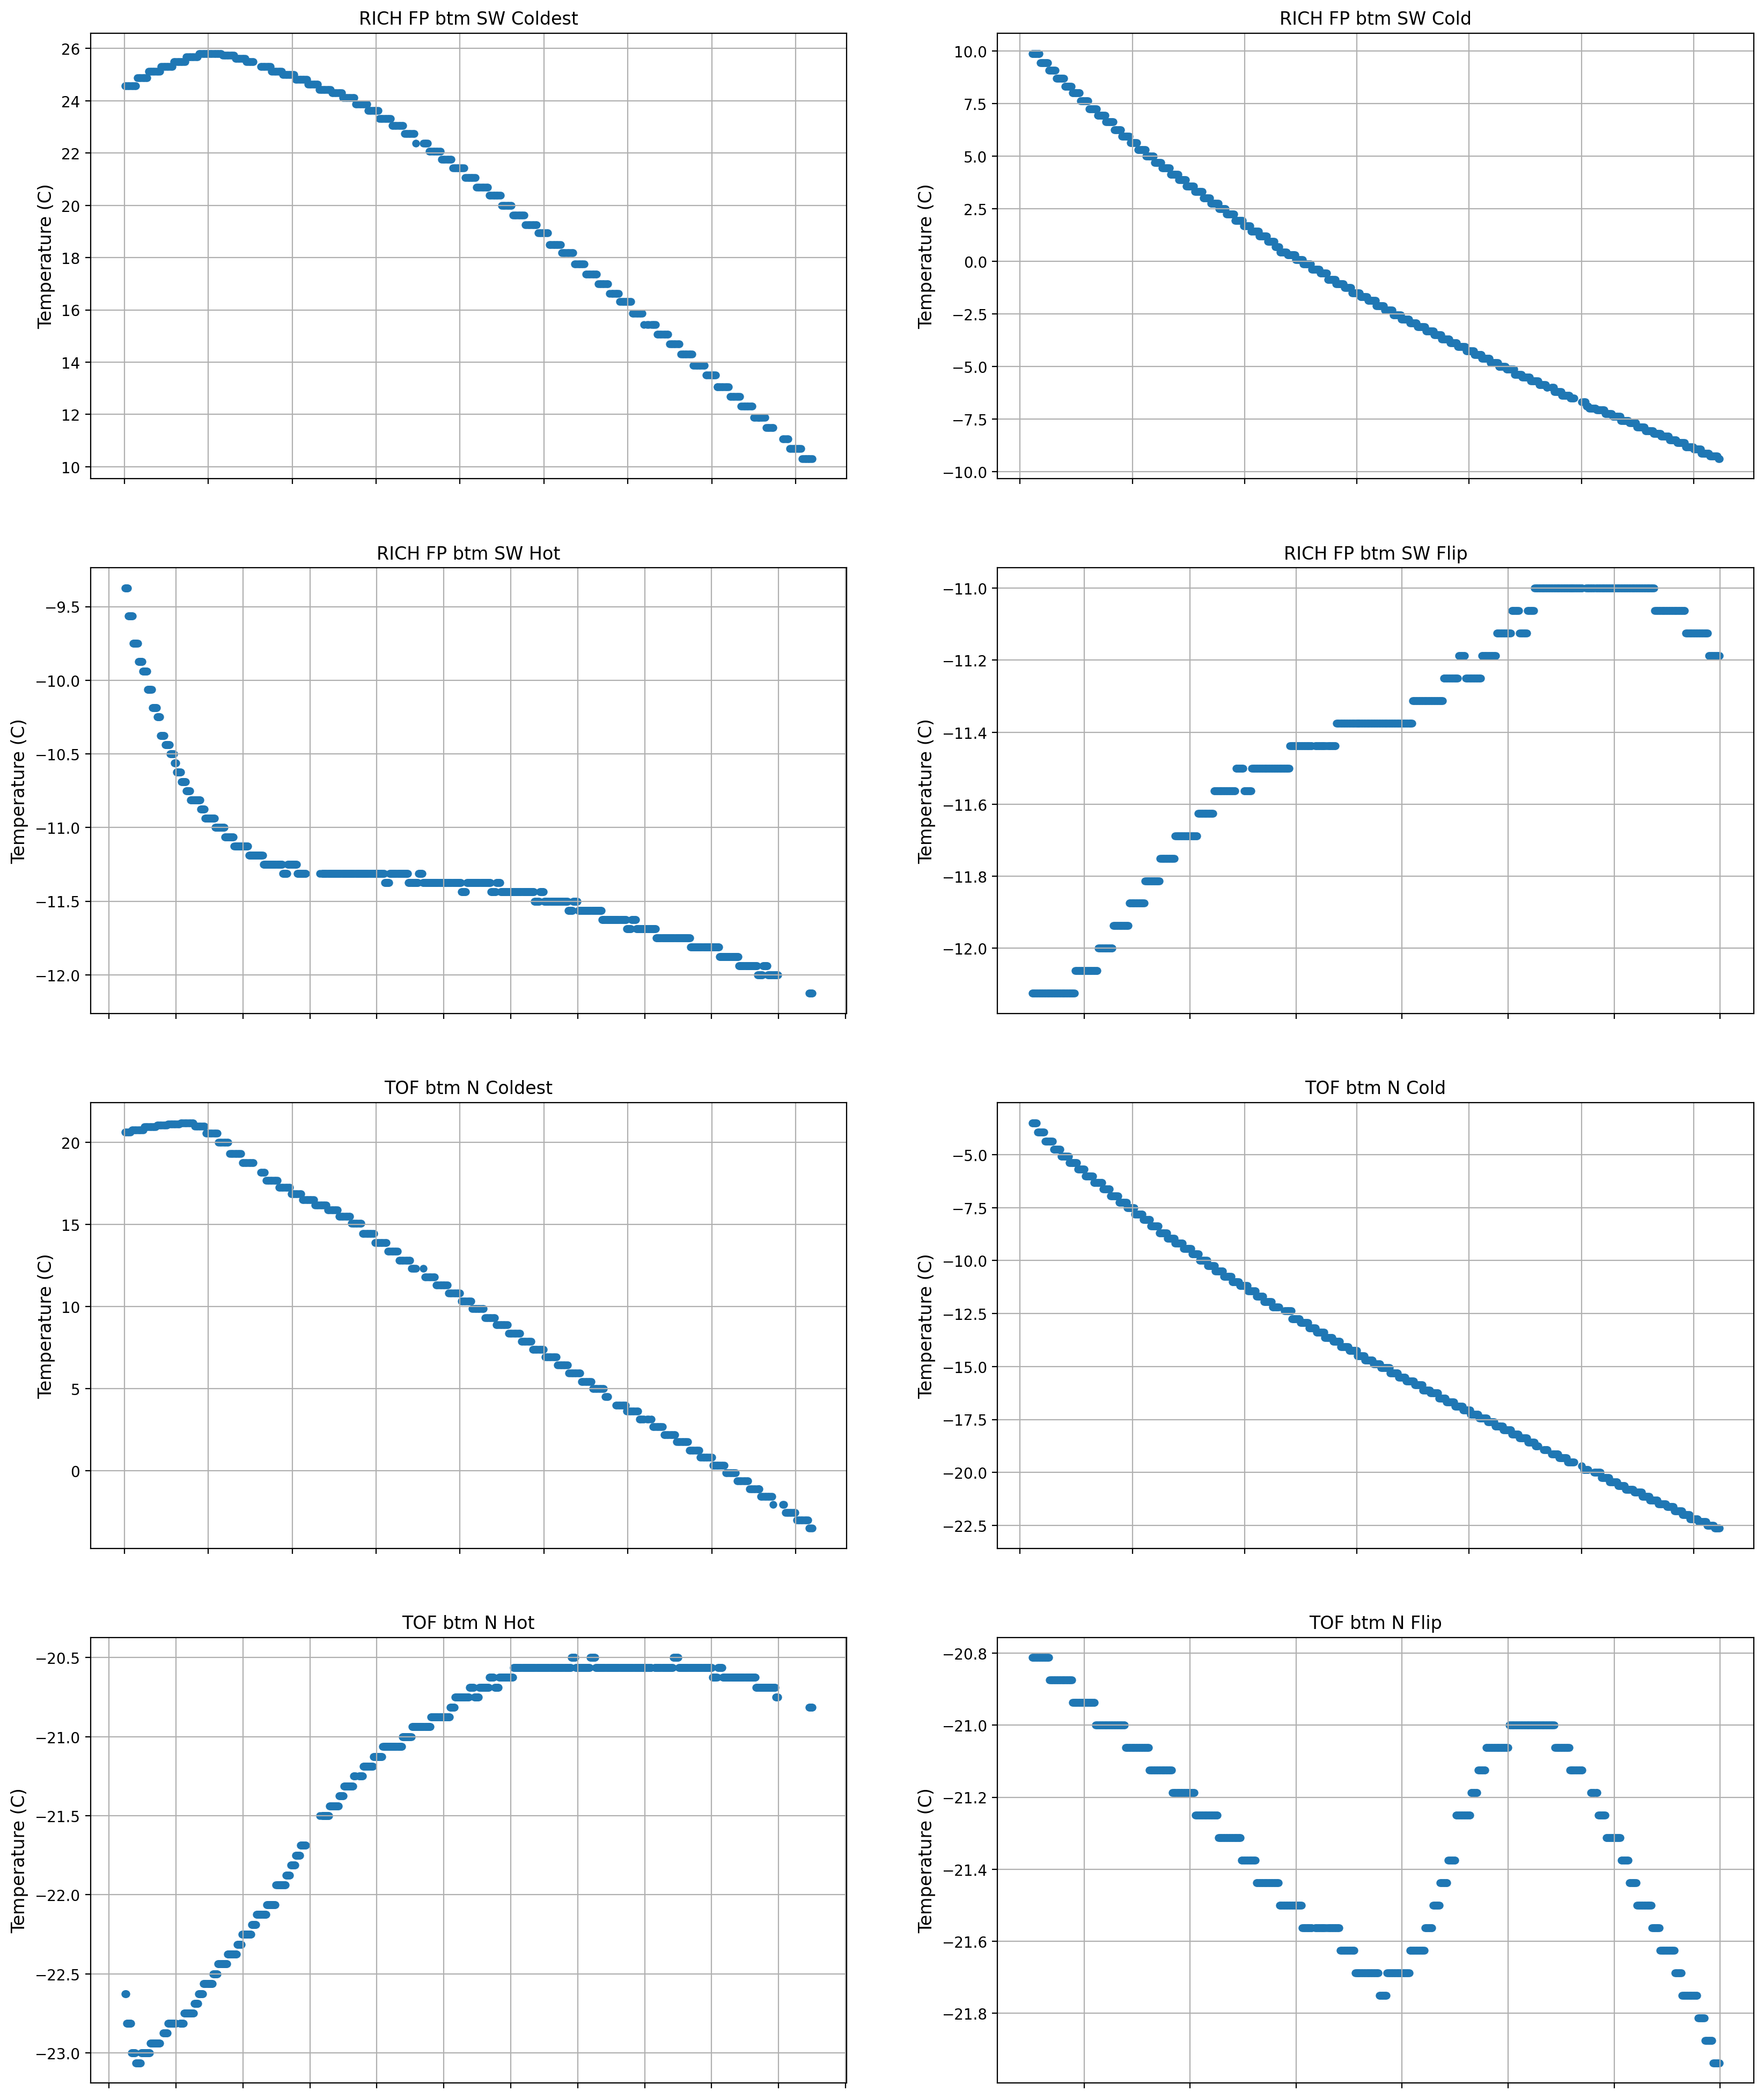

In [61]:
QuadGraphMaker()